# autoencoder try on fashion mnist dataset

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import os
from os import path

## data loading, visualizing, preprocessing

In [5]:
train_fashion_mnist_dataset = torchvision.datasets.FashionMNIST('../datasets/fashion_mnist/', download=True, train=True)
test_fashion_mnist_dataset = torchvision.datasets.FashionMNIST('../datasets/fashion_mnist/', download=True, train=False)

In [6]:
train_dataset = train_fashion_mnist_dataset.data

In [13]:
train_imgs, train_lables = train_fashion_mnist_dataset.data, train_fashion_mnist_dataset.targets
test_imgs, test_labels = test_fashion_mnist_dataset.data, test_fashion_mnist_dataset.targets

print(train_imgs.shape, test_labels.shape)
print(test_imgs.shape, test_labels.shape)

torch.Size([60000, 28, 28]) torch.Size([10000])
torch.Size([10000, 28, 28]) torch.Size([10000])


### intuitionally visualization

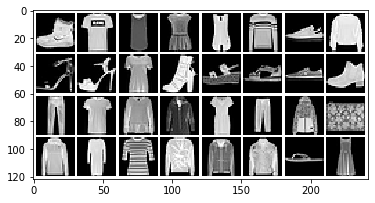

In [32]:
grid_imgs = torchvision.utils.make_grid(train_imgs[:32].unsqueeze(1), padding=2, pad_value=255).numpy()
plt.imshow(grid_imgs.transpose([1, 2, 0]))

### define dataloader and associated preprocessing

In [3]:
transforms = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     # -1~1 之间
     torchvision.transforms.Normalize((0.5,), (0.5,))]
)
train_fashion_mnist_dataset = torchvision.datasets.FashionMNIST('../datasets/fashion_mnist/', 
                                                                download=True, train=True, transform=transforms)
test_fashion_mnist_dataset = torchvision.datasets.FashionMNIST('../datasets/fashion_mnist/', 
                                                               download=True, train=False, transform=transforms)

In [4]:
train_loader = torch.utils.data.DataLoader(train_fashion_mnist_dataset, batch_size=4,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_fashion_mnist_dataset, batch_size=4, shuffle=False, num_workers=1)


## autoencoder model def

In [2]:
class AutoEncoder(torch.nn.Module):
    """
    untied version
    """
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self._encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(True),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(True), 
            torch.nn.Linear(64, 12), 
            torch.nn.ReLU(True), 
            torch.nn.Linear(12, 2)
        )
        self._decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 12),
            torch.nn.ReLU(True),
            torch.nn.Linear(12, 64),
            torch.nn.ReLU(True),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(True), 
            torch.nn.Linear(128, 28 * 28), 
            torch.nn.Tanh()
        )
        
    def encode(self, x):
        return self._encoder(x)
    
    def decode(self, x):
        return self._decoder(x)
    
    def forward(self, input_data):
        return self.decode(self.encode(input_data))

### training loop

In [85]:

def train(train_loader, test_loader, model, opt, criterion, max_epoch=100, ckpt_base='./ckpt', saving_interval=10):
    train_loss_record = []
    val_loss_record = []
    min_val_loss = 10000
    
    for k in range(max_epoch):
        epoch_loss = 0.
        size = 0.
        ## train phase
        for img, _ in train_loader:
            batch = img.size(0)
            # flatten the img, b,h,w -> b,h*w
            img = img.view(batch, -1)
            reconstruction_img = model(img)
            # loss is averaged by batch
            loss = criterion(img, reconstruction_img)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            epoch_loss += loss * batch
            size += batch
        epoch_loss /= size
        train_loss_record.append(epoch_loss)
        print("Epoch {}, Train Loss {:.2f}".format(k, epoch_loss))
        if k % saving_interval == 0:
            saved_model_name = path.join(ckpt_base, 'e{:04}.pt'.format(k))
            torch.save(model.state_dict(), saved_model_name)
        
        ## validaiton phase
        val_loss = 0.
        val_size = 0.
        with torch.no_grad():
            for img, _ in test_loader:
                batch = img.size(0)
                # flatten the img, b,h,w -> b,h*w
                img = img.view(batch, -1)
                reconstruction_img = model(img)
                # loss is averaged by batch
                loss = criterion(img, reconstruction_img)
            
                val_loss += loss * batch
                val_size += batch
            
        val_loss = val_loss / val_size
        val_loss_record.append(val_loss)
        print("Epoch {}, Val Loss {:.2f}".format(k, val_loss))        
        if val_loss < min_val_loss:
            print('update min val loss from {:.4f} to {:.4f}'.format(min_val_loss, val_loss))
            min_val_loss = val_loss
            saved_model_name = path.join(ckpt_base, 'min_val_loss.pt'.format(k))
            torch.save(model.state_dict(), saved_model_name)
            
    return train_loss_record, val_loss_record
            
        


In [86]:
model = AutoEncoder()
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.MSELoss(reduction='mean')
train_loss_record, val_loss_record = train(test_loader, test_loader, model, opt, criterion)

Epoch 0, Train Loss 0.16
Epoch 0, Val Loss 0.14
update min val loss from 10000.00 to 0.14
Epoch 1, Train Loss 0.14
Epoch 1, Val Loss 0.13
update min val loss from 0.14 to 0.13
Epoch 2, Train Loss 0.13
Epoch 2, Val Loss 0.13
Epoch 3, Train Loss 0.13
Epoch 3, Val Loss 0.12
update min val loss from 0.13 to 0.12
Epoch 4, Train Loss 0.12
Epoch 4, Val Loss 0.12
update min val loss from 0.12 to 0.12
Epoch 5, Train Loss 0.12
Epoch 5, Val Loss 0.12
update min val loss from 0.12 to 0.12
Epoch 6, Train Loss 0.12
Epoch 6, Val Loss 0.12
update min val loss from 0.12 to 0.12
Epoch 7, Train Loss 0.12
Epoch 7, Val Loss 0.12
update min val loss from 0.12 to 0.12
Epoch 8, Train Loss 0.12
Epoch 8, Val Loss 0.11
update min val loss from 0.12 to 0.11
Epoch 9, Train Loss 0.12
Epoch 9, Val Loss 0.11
update min val loss from 0.11 to 0.11
Epoch 10, Train Loss 0.12
Epoch 10, Val Loss 0.11
Epoch 11, Train Loss 0.12
Epoch 11, Val Loss 0.12
Epoch 12, Train Loss 0.11
Epoch 12, Val Loss 0.11
update min val loss from

## inspect the best encoded feature

In [7]:
best_model = AutoEncoder()
best_state_dict = torch.load('ckpt/min_val_loss.pt')
best_model.load_state_dict(best_state_dict)
best_model.eval()

AutoEncoder(
  (_encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (_decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [8]:
sorted(best_state_dict.keys())

['_decoder.0.bias',
 '_decoder.0.weight',
 '_decoder.2.bias',
 '_decoder.2.weight',
 '_decoder.4.bias',
 '_decoder.4.weight',
 '_decoder.6.bias',
 '_decoder.6.weight',
 '_encoder.0.bias',
 '_encoder.0.weight',
 '_encoder.2.bias',
 '_encoder.2.weight',
 '_encoder.4.bias',
 '_encoder.4.weight',
 '_encoder.6.bias',
 '_encoder.6.weight']

In [14]:
train_embedding_label = []
for img, label in train_loader:
    batch = img.size(0)
    embedding = best_model.encode(img.view(batch, -1))
    embedding = embedding.detach().numpy()
    label = label.numpy()
    
    train_embedding_label.append((embedding, label))
    

In [15]:
print(len(train_embedding_label))

15000


In [65]:
label_dict = dict()
for embedding, label in train_embedding_label:
    for emd, lab in zip(embedding, label):
        label_dict.setdefault(lab, []).append(emd)

In [82]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(label_dict)))

In [88]:
colors[0]
print(colors.shape)

(10, 4)


In [90]:
rgb_colors = [x[:3] for x in colors]

In [92]:
rgb_colors = np.array(rgb_colors)

In [104]:
rgb_colors[0]

array([0.5, 0. , 1. ])

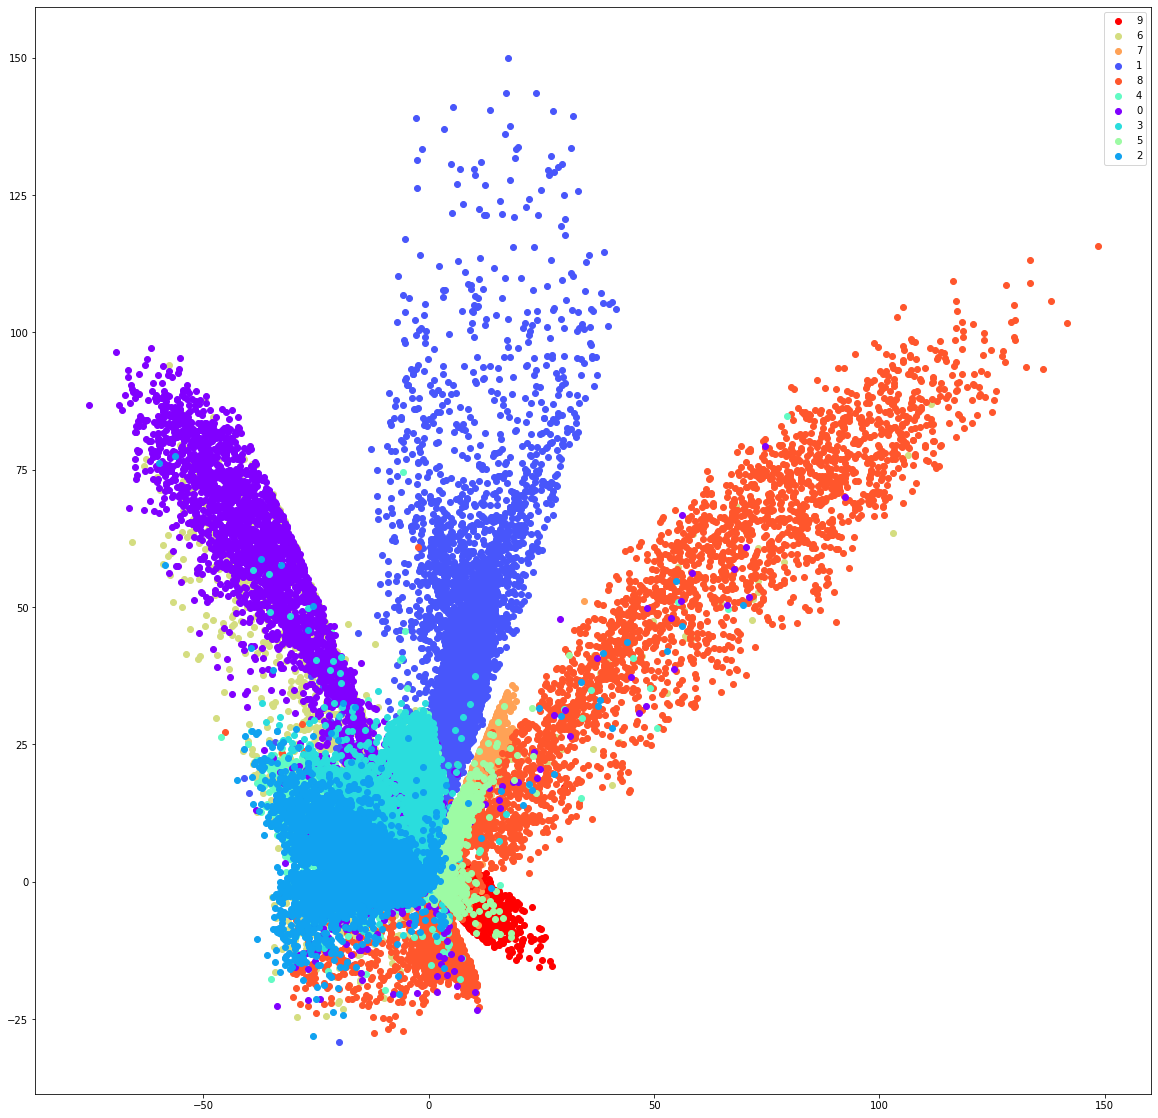

In [110]:
plt.figure(figsize=(20, 20))
for lab, cors in label_dict.items():
    cors = np.array(cors)
    plt.scatter(cors[:, 0], cors[:, 1], color=colors[lab], label=lab)
plt.legend()
plt.show()